# How to calculate indicators?

Pynar has been designed to be compliant with [xclim](https://xclim.readthedocs.io/en/stable/), a library of climate indicators. Therefore, calculating ecoclimatic indicators (i.e., climate indicator integrating crop phenology) is really easy. For this we use the `doy_bounds` time-selection argument of indicators that rely on the [select_time](https://xclim.readthedocs.io/en/stable/apidoc/xclim.core.html#xclim.core.calendar.select_time) function.

Let's see some examples!

<div class="alert alert-block alert-info">
<b>Note:</b> Some xclim's indicators don't support time selection.
</div>

## Import packages and load data



In [22]:
# import packages
from pathlib import Path

import xarray as xr
from xclim.core.units import convert_units_to
import matplotlib.pyplot as plt

import pynar.phenology as pn

# load the example dataset
DATA_PATH = r'C:\Users\1116_temp1\Documents\DATA'
fp = [f for f in (Path(DATA_PATH) / "NEX-GDDP-CMIP6/ACCESS-CM2/historical/").glob('*.nc')]
data = xr.open_mfdataset(fp)

data

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 23741, lon: 53, lat: 53)
Coordinates:
  * time     (time) datetime64[ns] 190kB 1950-01-01T12:00:00 ... 2014-12-31T1...
  * lon      (lon) float64 424B 166.1 166.4 166.6 166.9 ... 178.6 178.9 179.1
  * lat      (lat) float64 424B -46.88 -46.62 -46.38 ... -34.38 -34.12 -33.88
Data variables:
    hurs     (time, lat, lon) float32 267MB dask.array<chunksize=(23741, 53, 53), meta=np.ndarray>
    huss     (time, lat, lon) float32 267MB dask.array<chunksize=(23741, 53, 53), meta=np.ndarray>
    pr       (time, lat, lon) float32 267MB dask.array<chunksize=(23741, 53, 53), meta=np.ndarray>
    rlds     (time, lat, lon) float32 267MB dask.array<chunksize=(23741, 53, 53), meta=np.ndarray>
    rsds     (time, lat, lon) float32 267MB dask.array<chunksize=(23741, 53, 53), meta=np.ndarray>
    sfcWind  (time, lat, lon) float32 267MB dask.array<chunksize=(23741, 53, 53), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 267MB dask.array<chunksize=(23741, 53, 53), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 267MB dask.array<chunksize=(23741, 53, 53), meta=np.ndarray>
    tas      (time, lat, lon) float32 267MB dask.array<chunksize=(23741, 53, 53), meta=np.ndarray>
Attributes: (12/30)
    CDI:                   Climate Data Interface version 1.9.3 (http://mpime...
    Conventions:           CF-1.7
    history:               Fri Nov 24 09:47:35 2023: cdo mergetime GDDP-CMIP6...
    source:                BCSD
    institution:           NASA Earth Exchange, NASA Ames Research Center, Mo...
    _NCProperties:         version=2,netcdf=4.9.3-development,hdf5=1.12.2
    ...                    ...
    History:               Translated to CF-1.0 Conventions by Netcdf-Java CD...
    geospatial_lat_min:    -47.0
    geospatial_lat_max:    -33.75
    geospatial_lon_min:    166.0
    geospatial_lon_max:    179.25
    CDO:                   Climate Data Operators version 1.9.4rc1 (http://mp...

## Phenological Stages Calculation

We can start by calculating the phenological stages for wheat with a early-intermediate maturity.

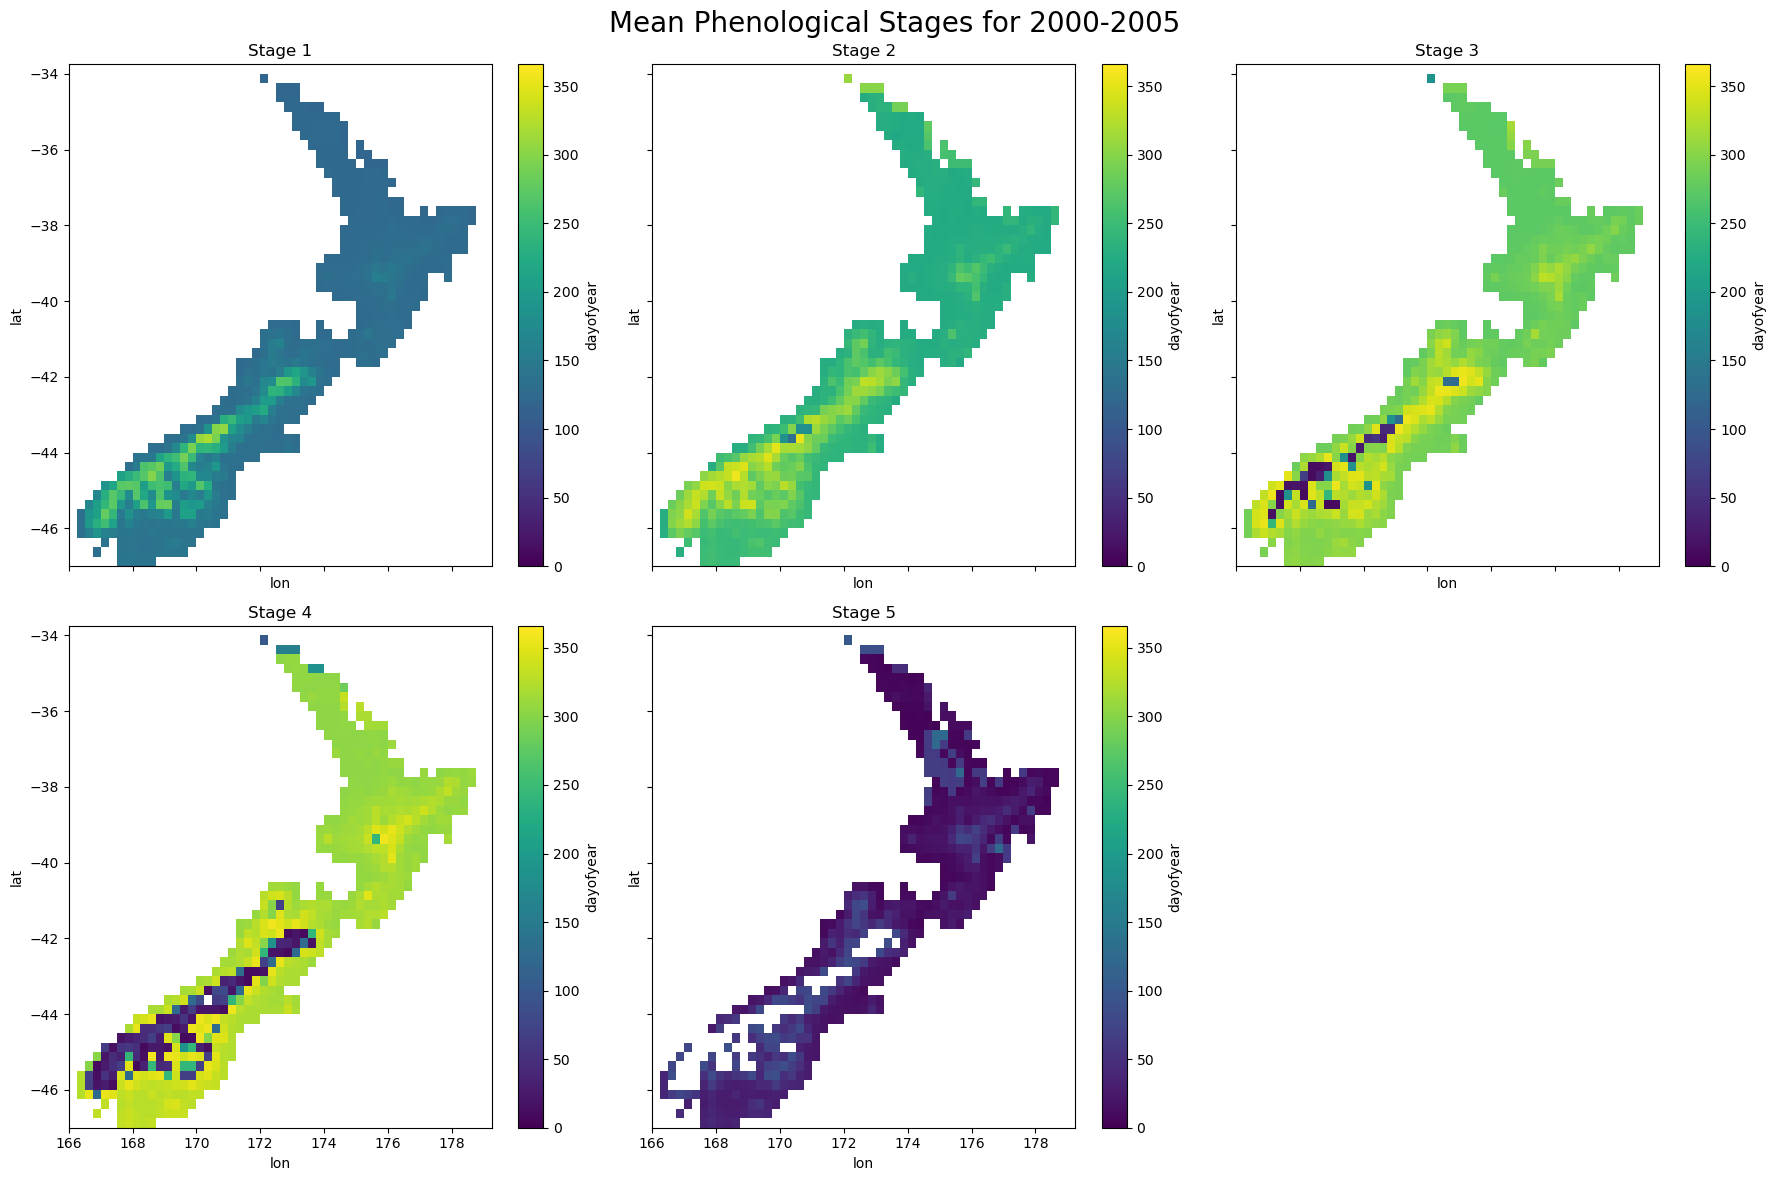

In [ ]:
crop_params = {
    "sensiphot": 0,
    "phobase": 6.3,
    "phosat": 20,
    "optimum_temp": 6.5,
    "thermal_sensi": 10,
    "vern_mindays": 7,
    "vern_ndays": 55,
    "tmin_thresh": 0,
    "tmax_thresh": 28,
    "tstop_thresh": 100
}

s1 = pn.phenological_stage(
    tas=data.tas,
    thresh=120,
    params=crop_params, # all parameters to use
    is_photoperiod=True,  # use photoperiod
    is_vernalisation=False,  # do not use vernalisation
    start_cycle_doy=105,  # sowing date
    freq="YS-APR"
)

s2 = pn.phenological_stage(
    tas=data.tas,
    thresh=210,
    params=crop_params, # all parameters to use
    is_photoperiod=True,  # use photoperiod
    is_vernalisation=True,  # use vernalisation
    start_cycle_doy=105,  # sowing date
    from_doy=s1,  # previous stage
    freq="YS-APR"
)

s3 = pn.phenological_stage(
    tas=data.tas,
    thresh=260,
    params=crop_params,
    is_photoperiod=True,
    is_vernalisation=True,
    start_cycle_doy=105,
    from_doy=s2,
    freq="YS-APR"
)

s4 = pn.phenological_stage(
    tas=data.tas,
    thresh=245,
    params=crop_params,
    is_photoperiod=True,
    is_vernalisation=True,
    start_cycle_doy=105,
    from_doy=s3,
    freq="YS-APR"
)

s5 = pn.phenological_stage(
    tas=data.tas,
    thresh=700,
    params=crop_params,
    is_photoperiod=True,
    is_vernalisation=False, # no vernalisation for maturity
    start_cycle_doy=105,
    from_doy=s4,
    freq="YS-APR"
)

# plot mean dates for all stages for 2000-2005
fig, ax = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)
s1.sel(time=slice("2000", "2005")).mean(dim="time").plot(ax=ax[0, 0], vmin=0, vmax=366, cmap="viridis")
ax[0, 0].set_title("Stage 1")
s2.sel(time=slice("2000", "2005")).mean(dim="time").plot(ax=ax[0, 1], vmin=0, vmax=366, cmap="viridis")
ax[0, 1].set_title("Stage 2")
s3.sel(time=slice("2000", "2005")).mean(dim="time").plot(ax=ax[0, 2], vmin=0, vmax=366, cmap="viridis")
ax[0, 2].set_title("Stage 3")
s4.sel(time=slice("2000", "2005")).mean(dim="time").plot(ax=ax[1, 0], vmin=0, vmax=366, cmap="viridis")
ax[1, 0].set_title("Stage 4")
s5.sel(time=slice("2000", "2005")).mean(dim="time").plot(ax=ax[1, 1], vmin=0, vmax=366, cmap="viridis")
ax[1, 1].set_title("Stage 5")
ax[1, 2].axis("off")
plt.suptitle("Mean Phenological Stages for 2000-2005", fontsize=20)
plt.tight_layout()
plt.show()


## Ecoclimatic indicators

Now that we have the phenological stages, we can calculate some ecoclimatic indicators using xclim package. Let's say we want to get:
- the number of days with tasmin below -2°C between phenological stages 1 and 2.
- the number of days with tasmax above 25°C between phenological stages 4 and 5.
- the total precipitation over the growing cycle (sowing date to stage 5).

### Frost Days

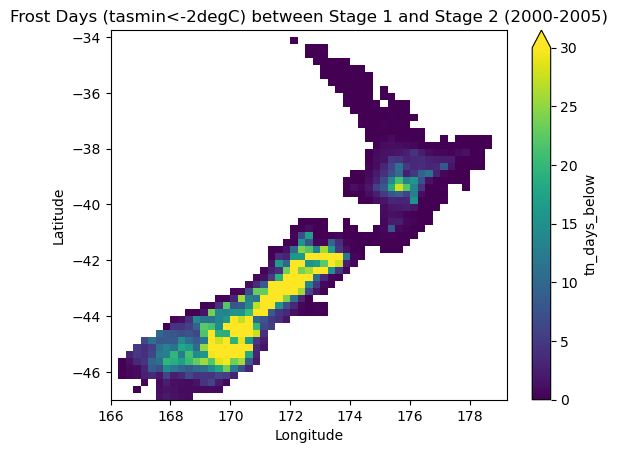

In [37]:
from xclim.indicators.atmos import tn_days_below

fd = tn_days_below(data.tasmin, thresh = "-2 degC", doy_bounds=(s1, s2), freq="YS-APR") # we have to use the same frequency as the phenology stages

# plot the number of frost days: mean 2000-2005
fd.sel(time=slice("2000", "2005")).mean(dim="time").plot(vmin=0, vmax=30, cmap="viridis")
plt.title("Frost Days (tasmin<-2degC) between Stage 1 and Stage 2 (2000-2005)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### Hot Days

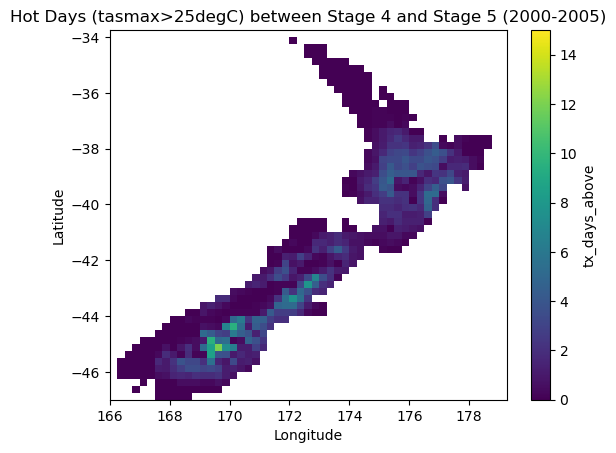

In [38]:
from xclim.indicators.atmos import tx_days_above

hd = tx_days_above(data.tasmax, thresh = "25 degC", doy_bounds=(s4, s5), freq="YS-APR")

# plot the number of hot days: mean 2000-2005
hd.sel(time=slice("2000", "2005")).mean(dim="time").plot(vmin=0, vmax=15, cmap="viridis")
plt.title("Hot Days (tasmax>25degC) between Stage 4 and Stage 5 (2000-2005)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

We can see from the phenological stages plot that some cells don't reach the stage 5. Thus, we need to mask this data afer calculating the indicator.

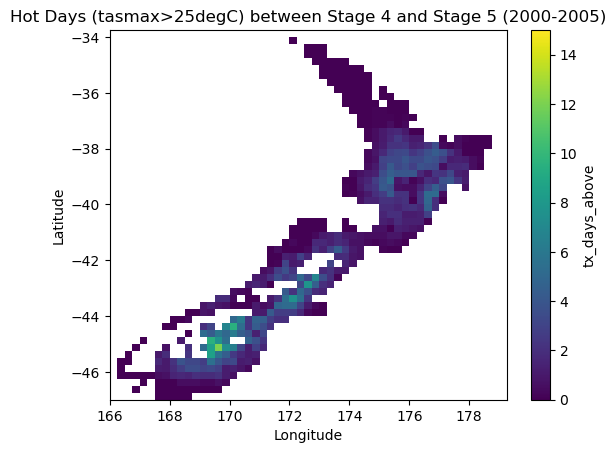

In [42]:
hd = hd.where(s5.notnull())  # filter out values where stage 5 is not reached

# replot the data
hd.sel(time=slice("2000", "2005")).mean(dim="time").plot(vmin=0, vmax=15, cmap="viridis")
plt.title("Hot Days (tasmax>25degC) between Stage 4 and Stage 5 (2000-2005)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Total Precipitation

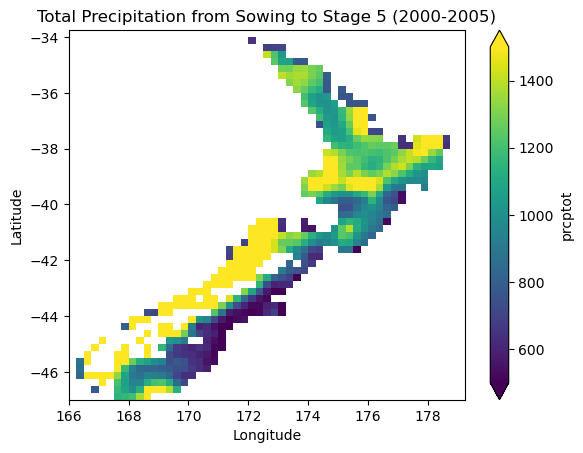

In [43]:
from xclim.indicators.atmos import precip_accumulation

pr = precip_accumulation(data.pr, doy_bounds=(105, s5), freq="YS-APR") # 105 is the sowing date
pr = pr.where(s5.notnull())  # filter out values where stage 5 is not reached

# plot the total precipitation: mean 2000-2005
pr.sel(time=slice("2000", "2005")).mean(dim="time").plot(vmin=500, vmax=1500, cmap="viridis")
plt.title("Total Precipitation from Sowing to Stage 5 (2000-2005)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()